In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

torch.manual_seed(0)

# Borehole Problem 

This notebook shows an example about how to implement Langevin Bi-fidelity Importance Sampling (L-BF-IS) to the failure probability estimation on the Borehole problem. 

## Step 1: Define LF and HF functions for failure probability estimation

We define the status of failure when the quantity of interests (QoIs) are higher than some thresholds. For the HF function, we define the threshold to be 800. For the LF function, the threshold is roughly estimated as 1000. Noted that the threshold for the LF function is usually estimated from our rough estimation from our knowledge on HF threshold. For example, we assume to know the approximated range for the HF failure probability ~1% in this problem. Since sampling LF samples are relatively cheap, we let the LF threshold to be a value such that the LF failure estimation is also closed to ~1%.

In [2]:
# define Borehole QoI functions
#####################################################
#
# Borehole function bi-fidelity data (separate sample p function)
# source: https://www.sfu.ca/~ssurjano/borehole.html
#
#####################################################

def transform_p_bh(x): # transform xi into correct range
    if x.ndim != 2 or len(x[0]) != 8:
        raise ValueError('Incorrect xi structure.')
    new_x = torch.zeros_like(x)
    new_x[:,0] = 0.10 + 0.0161812 * x[:,0]
    new_x[:,1] = (7.71 + 1.0056 * x[:,1]).exp()
    new_x[:,2] = (115600 - 63070) * x[:,2] + 63070
    new_x[:,3] = (1110 - 990) * x[:,3] + 990
    new_x[:,4] = (116 - 63.1) * x[:,4] + 63.1
    new_x[:,5] = (820 - 700) * x[:,5] + 700
    new_x[:,6] = (1680 - 1120) * x[:,6] + 1120
    new_x[:,7] = (12045 - 9855) * x[:,7] + 9855
    return new_x

def bh_LF(x):
    x = transform_p_bh(x)

    lnrrw  = torch.log(x[:,1]/x[:,0])
    top    = 2 * np.pi * x[:,2] * (x[:,3] - x[:, 5])
    bottom = lnrrw * (1 + 2 * x[:,6] * x[:,2]/(lnrrw * x[:,0] * x[:,7]) + x[:,2]/x[:,4])
    return top/bottom

def bh_HF(x):
    x = transform_p_bh(x)

    lnrrw  = torch.log(x[:,1]/x[:,0])
    top    = 5 * x[:,2] * (x[:,3] - x[:, 5])
    bottom = lnrrw * (1.5 + 2 * x[:,6] * x[:,2]/(lnrrw * x[:,0] * x[:,7]) + x[:,2]/x[:,4])
    return top/bottom

def sample(N):
    return torch.hstack((torch.randn(N, 2),torch.rand(N,6)))

In [3]:
# define the input dimension
num_variable = 8

# define LF and HF functions
def h_LF(x):
    ind1 = (x[:,:2] < -10).any(axis=1) + (x[:,:2] > 10).any(axis=1)
    ind2 = (x[:,2:] < -1).any(axis=1) + (x[:,2:] > 1).any(axis=1)
    ans = 1000 - bh_LF(x)
    ans[ind1] = torch.norm(x[ind1], dim=1)**2
    ans[ind2] = 100 * torch.norm(x[ind2], dim=1)**2
    return ans

def h_HF(x):
    ind1 = (x[:,:2] < -10).any(axis=1) + (x[:,:2] > 10).any(axis=1)
    ind2 = (x[:,2:] < -1).any(axis=1) + (x[:,2:] > 1).any(axis=1)
    ans = 800 - bh_HF(x)
    ans[ind1] = torch.norm(x[ind1], dim=1)**2
    ans[ind2] = 100 * torch.norm(x[ind2], dim=1)**2
    return ans

## Step 2: Estimating parameters

The most key (hyper-)parameter of L-BF-IS is $\ell$. We propose two methods to approximate the optimal value of $\ell$ so that the estimator variance is reduced. The following codes are used for implementing these two methods.

In [4]:
# selcting optimal ell
L = int(1e2)
M = int(1e6)
num_trial_ell = 10

# fix samples
samps_M = sample(M)
h_samps_M = h_LF(samps_M)

# Compute the true failure probability
# you don't (cannot) do this in practice
ExH = np.mean((h_HF(samps_M) < 0).detach().numpy())
print("The probability of h_HF < 0 is: ", ExH)

# define function Z(ell) and a variance function for estimator variation computation
def Zl(ell):
    return (-ell * torch.tanh(h_samps_M)).exp().sum() / M
def V(ell, A, B):
    return Zl(ell) * ((ell * torch.tanh(B)).exp()[A < 0]).sum()

# start collecting estimator variance given different ell
# we find the best ell using line search
ell_lst = torch.linspace(1, 20, 43)
Var1_lst, Var2_lst = [], []
for _ in range(num_trial_ell):
    samps_L = sample(L)
    h_samps_L = h_HF(samps_L)
    h_samps_LL = h_LF(samps_L)
    V_lst = [V(ell, h_samps_L, h_samps_LL).item() for ell in ell_lst]
    Var1_lst.append(V_lst)

    samps_L = sample(M)
    h_samps_L = h_LF(samps_L)
    h_samps_LL = h_LF(samps_L)
    Var_lst = [V(ell, h_samps_L, h_samps_LL).item() for ell in ell_lst]
    Var2_lst.append(Var_lst)
Var1_lst, Var2_lst = np.array(Var1_lst), np.array(Var2_lst)
Var2_lst /= (M / L)
Var1_mean, Var2_mean = np.nanmean(Var1_lst, axis=0), np.nanmean(Var2_lst, axis=0)
Var1_std, Var2_std = np.nanstd(Var1_lst, axis=0), np.nanstd(Var2_lst, axis=0)

The probability of h_HF < 0 is:  0.055575


Smallest $\ell$ for approach one:  tensor(20.)
Smallest $\ell$ for approach two:  tensor(3.2619)


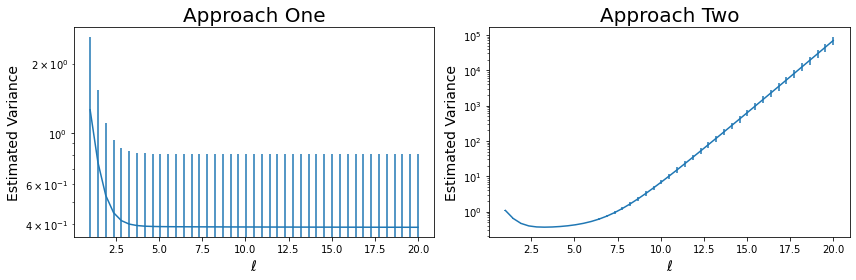

In [5]:
# Visualize the estimation
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].errorbar(ell_lst, Var1_mean, yerr=1.94*Var1_std)
axs[0].set_xlabel(r'$\ell$', fontsize=14)
axs[0].set_ylabel('Estimated Variance', fontsize=14)
axs[0].set_title('Approach One', fontsize=20)
axs[0].set_yscale('log')

axs[1].errorbar(ell_lst, Var2_mean, yerr=1.94*Var2_std)
axs[1].set_xlabel(r'$\ell$', fontsize=14)
axs[1].set_ylabel('Estimated Variance', fontsize=14)
axs[1].set_title('Approach Two', fontsize=20)
axs[1].set_yscale('log')

plt.tight_layout()

# fig.savefig('../figures/borehole-ell.pdf', dpi=300, bbox_inches='tight')

print(r'Smallest $\ell$ for approach one: ', ell_lst[np.argmin(Var1_mean)])
print(r'Smallest $\ell$ for approach two: ', ell_lst[np.argmin(Var2_mean)])

# we choose the value of ell that minimize our estimator variance
ell = ell_lst[np.argmin(Var2_mean)]

## Step 3: Apply the Langevin algorithm for sampling the biasing distribution 

The following codes implementing the unadjusted Langevin algorithm and the Metropolis-adjusted Langevin algorithm for sampling the biasing distribution. 

The codes are built based on [this GitHub page](https://github.com/abdulfatir/langevin-monte-carlo).

In [6]:
from tqdm import tqdm
# compute the value of Z(ell) given fixed ell
Zc = Zl(ell)

def potential(z: torch.Tensor): # evaluate the potential function for the given z
    return ell * torch.tanh(h_LF(z)) - torch.norm(z[:,0])**2 - torch.norm(z[:,1])**2  

def log_Q(potential, z_prime, z, step):
    z.requires_grad_()
    grad = torch.autograd.grad(potential(z).mean(), z)[0]
    return -(torch.norm(z_prime - z + step * grad, p=2, dim=1) ** 2) / (4 * step)

def metropolis_adjusted_langevin_algorithm(iter_num=1000, step=0.01, burn_in=1000):
    Z0 = torch.zeros(1, num_variable)
    Zi = Z0
    samples = []
    pbar = tqdm(range(iter_num + burn_in))
    for i in pbar:
        Zi.requires_grad_()
        u = potential(Zi).mean()
        grad = torch.autograd.grad(u, Zi)[0]
        prop_Zi = Zi.detach() - step * grad + np.sqrt(2 * step) * torch.randn(1, num_variable)
        log_ratio = -potential(prop_Zi).mean() + potential(Zi).mean() +\
                    log_Q(potential, Zi, prop_Zi, step) - log_Q(potential, prop_Zi, Zi, step)
        if torch.rand(1) < torch.exp(log_ratio):
            Zi = prop_Zi
        samples.append(Zi.detach())
    return torch.cat(samples, 0)[burn_in:]

def weight(x:torch.Tensor): # evaluate the unnormalized weight for the given xi
    wt = Zc * (ell * torch.tanh(h_LF(x))).exp()
    return wt

q_lst = metropolis_adjusted_langevin_algorithm(iter_num=int(1e4), step=1e-4, burn_in=int(1e3))
# check the number failures given the biasing distribution
print('The number of failures sampled by q is ', (h_HF(q_lst) < 0).sum().item())
# check the number of biasing samples that are out of the domain of this problem
q_lst2 = q_lst[(q_lst[:,2:] < 1).all(axis=1) * (q_lst[:,2:] > -1).all(axis=1)]
print('The number of meaningful q samples is ', q_lst2.shape[0])


100%|██████████| 11000/11000 [01:19<00:00, 137.92it/s]

The number of failures sampled by q is  9850
The number of meaningful q samples is  10000


## Step 3.5: Implement the Gaussian mixture method for building the biasing distribution

In [7]:
from sklearn.mixture import GaussianMixture
# Apply Gaussian mixture model for IS
GM_samps_all = samps_M[h_LF(samps_M) < 0]
print('There are ', GM_samps_all.shape[0], 'samples producing LF failure.')
# Choose 1000 of them
GM_trains = GM_samps_all[:10000]
print('The number of samples used in the Gaussian mixture model is', GM_trains.shape[0])
GM_model = GaussianMixture(n_components=10, random_state=0).fit(GM_trains.detach().numpy())
GM_samps = GM_model.sample(10000)[0]
GM_wegts = 0.5**num_variable * (np.exp(- GM_model.score_samples(GM_samps)))
selected_ind = ((GM_samps[:,2:] < 1).all(axis=1) * (GM_samps[:,2:] > -1).all(axis=1))
GM_samps, GM_wegts = GM_samps[selected_ind], GM_wegts[selected_ind]
print(GM_samps.shape, GM_wegts.shape)

There are  58203 samples producing LF failure.
The number of samples used in the Gaussian mixture model is 10000
(8310, 8) (8310,)


## Step 4: Compute results

In [8]:
Max_N = min(len(q_lst), len(GM_samps))
MC_N_lst = (10**np.linspace(1, 4, 10)).astype('int')
MC = []
IS = []
GM = []
num_trial = 1000
for j in range(num_trial):
    MC_est_lst = []
    IS_est_lst = []
    GM_est_lst = []
    for MC_N in MC_N_lst:
        xi_p = sample(MC_N) # sample MC xi_p
        ind = np.random.choice(Max_N,MC_N)
        xi_q = q_lst[ind] # sample xi_q
        xi_g = torch.from_numpy(GM_samps[ind]).type(torch.FloatTensor) # sample xi_g
        wt_q = weight(xi_q) / MC_N
        wt_g = GM_wegts[ind] / MC_N
        MC_est_lst.append(np.mean((h_HF(xi_p) < 0).detach().numpy()))
        IS_est_lst.append(wt_q[h_HF(xi_q) < 0].sum().item())
        GM_est_lst.append(wt_g[h_HF(xi_g) < 0].sum().item())
    MC.append(MC_est_lst)
    IS.append(IS_est_lst)
    GM.append(GM_est_lst)

MC      = np.array(MC)
IS      = np.array(IS)
GM      = np.array(GM)
MC_mean = np.nanmean(MC, axis=0)
MC_std  = np.nanstd(MC, axis=0)
IS_mean = np.nanmean(IS, axis=0)
IS_std  = np.nanstd(IS, axis=0)
GM_mean = np.nanmean(GM, axis=0)
GM_std  = np.nanstd(GM, axis=0)
MC_err  = ((MC - ExH)**2)
IS_err  = ((IS - ExH)**2)
GM_err  = ((GM - ExH)**2)
MC_rmse = np.sqrt(np.nanmean(MC_err, axis=0))
IS_rmse = np.sqrt(np.nanmean(IS_err, axis=0))
GM_rmse = np.sqrt(np.nanmean(GM_err, axis=0))

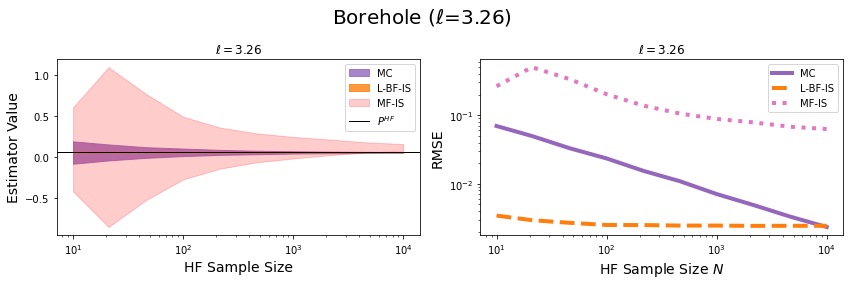

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle(f'Borehole ($\ell$={ell:.2f})', fontsize=20)
scale = 1.96

axs[0].fill_between(MC_N_lst, MC_mean-scale*MC_std, MC_mean+scale*MC_std,color='tab:purple',alpha=0.8,label='MC')
axs[0].fill_between(MC_N_lst, IS_mean-scale*IS_std, IS_mean+scale*IS_std,color='tab:orange',alpha=0.8,label='L-BF-IS')
axs[0].fill_between(MC_N_lst, GM_mean-scale*GM_std, GM_mean+scale*GM_std,color='r',alpha=0.2,label='MF-IS')
axs[0].axhline(ExH,c='k',label=r'$P^{HF}$',lw=1.0)
axs[0].set_xscale('log')
axs[0].set_xlabel('HF Sample Size', fontsize=14)
axs[0].set_ylabel('Estimator Value', fontsize=14)
axs[0].legend()
axs[0].set_title(f'$\ell={ell:.2f}$')

axs[1].plot(MC_N_lst, MC_rmse,color='tab:purple',alpha=1.0,label='MC',lw=4.0)
axs[1].plot(MC_N_lst, IS_rmse,color='tab:orange',alpha=1.0,label='L-BF-IS',lw=4.0,ls='--')
axs[1].plot(MC_N_lst, GM_rmse,color='tab:pink',alpha=1.0,label='MF-IS',lw=4.0,ls=':')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'HF Sample Size $N$', fontsize=14)
axs[1].set_ylabel('RMSE', fontsize=14)
axs[1].legend()
axs[1].set_title(f'$\ell={ell:.2f}$')

fig.tight_layout()
# fig.savefig(f'../figures/borehole-lp-ell{ell:.2f}.pdf', dpi=300)